<a href="https://colab.research.google.com/github/JJay1010/K-software_-/blob/main/EunjuKang/project_03/03_Covid_19_230114_commit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project03. 코로나 데이터 분석

시계열 예측(Time-Series Forecasting)
시계열(Time Series) 데이터란 시간의 흐름에 따라 순차적으로(sequentially) 기록된 데이터로, 이러한 시계열 데이터를 분석하여 미래를 예측하는 문제가 바로 시계열 예측 문제이다. 주로 경제 지표나 주식, 상품 수요를 예측하는데 사용된다. 예측을 하기 위해선 거기에 영향을 미치는 변수가 무엇이 있는지 찾아야 한다.

해당 코로나 확진자 데이터의 경우 가장 간단하게 생각해 볼 수 있는 것은 확진자수 예측이었다. 따라서 해당 데이터가 시계열 예측을 수행하기에 적절한 데이터를 가지고 있는지 알아보고자 했다. 시계열 예측문제에는 LSTM 모델을 많이 사용하는데 우선 모델을 학습시키기 위한 데이터를 얻기 위해 데이터 분석 및 시각화를 통해서 확진자수에 어떤 변수가 영향을 미치고 있는지 찾고자 했다.  

목표: 코로나19 확진자 현황 데이터 분석하여 유의미한 정보를 도출하는 것이 목표, 
데이터 분석을 위해 데이터를 정제하고 시각화를 수행한다. 


분석 및 시각화에 필요한 라이브러리

In [265]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [266]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

버전:  3.2.2
설치 위치:  /usr/local/lib/python3.8/dist-packages/matplotlib/__init__.py
설정 위치:  /root/.config/matplotlib
캐시 위치:  /root/.cache/matplotlib


In [267]:
print ('설정파일 위치: ', mpl.matplotlib_fname())

설정파일 위치:  /usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/matplotlibrc


In [268]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# ttf 폰트 전체갯수
print(len(font_list)) 

27


In [269]:
font_list[:10] 

['/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf']

In [270]:
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

[('NanumMyeongjo', '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'),
 ('NanumSquareRound', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf'),
 ('NanumSquare', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'),
 ('NanumMyeongjo', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf'),
 ('NanumBarunGothic', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'),
 ('NanumSquare', '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf'),
 ('NanumSquareRound', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'),
 ('NanumGothic', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'),
 ('NanumGothic', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'),
 ('NanumBarunGothic',
  '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf')]

In [271]:
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path).get_name()
print(font_name)

NanumBarunGothic


In [272]:
plt.rc('font', family=font_name)
plt.rcParams["figure.figsize"] = (8, 4)

%matplotlib inline

In [273]:
# # 한글 출력을 위한 폰트 다운로드

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

폰트 다운으로 한글 깨짐 현상 해결하고자 했는데 실패 

-> 추후 보완하기로 함

## 1. 데이터 확인하기

### csv 데이터 불러오기

In [274]:
import pandas as pd
import numpy as np

In [275]:
patient_file = '/content/drive/MyDrive/03_Covid/patient_info.csv'

patient_df = pd.read_csv(patient_file)

patient_df

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,5748,10.21.,25530,NaN,NaN,양천구,NaN,감염경로 조사중,NaN,NaN,NaN,2020-10-22,2020-10-22,Y
1,5747,10.21.,25528,NaN,NaN,강동구,NaN,강남서초 지인모임,NaN,NaN,NaN,2020-10-22,2020-10-22,Y
2,5746,10.21.,25525,NaN,NaN,강남구,NaN,기타 확진자 접촉,NaN,NaN,NaN,2020-10-22,2020-10-22,Y
3,5745,10.21.,25517,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,NaN,NaN,2020-10-22,2020-10-22,Y
4,5744,10.21.,25504,NaN,NaN,관악구,NaN,기타 확진자 접촉,NaN,NaN,NaN,2020-10-22,2020-10-22,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5743,5,1.31.,9,NaN,NaN,성북구,NaN,#5 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-10-22,2020-10-23,Y
5744,4,1.30.,7,NaN,NaN,마포구,중국 우한시,해외 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-10-22,2020-10-23,Y
5745,3,1.30.,6,NaN,NaN,종로구,NaN,#3 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-10-22,2020-10-23,Y
5746,2,1.30.,5,NaN,NaN,중랑구,중국 우한시,해외 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-10-22,2020-10-23,Y


In [276]:
location_file = '/content/drive/MyDrive/03_Covid/seoul_location_info.csv'

location_df = pd.read_csv(location_file)

location_df

,순번,시군구코드,시군구명_한글,시군구명_영문,ESRI_PK,위도,경도
0,1,11320,도봉구,Dobong-gu,0,37.665861,127.031767
1,2,11380,은평구,Eunpyeong-gu,1,37.617612,126.922700
2,3,11230,동대문구,Dongdaemun-gu,2,37.583801,127.050700
3,4,11590,동작구,Dongjak-gu,3,37.496504,126.944307
4,5,11545,금천구,Geumcheon-gu,4,37.460097,126.900155
5,6,11530,구로구,Guro-gu,5,37.495486,126.858121
6,7,11110,종로구,Jongno-gu,6,37.599100,126.986149
7,8,11305,강북구,Gangbuk-gu,7,37.646995,127.014716
8,9,11260,중랑구,Jungnang-gu,8,37.595379,127.093967
9,10,11680,강남구,Gangnam-gu,9,37.495985,127.066409


In [447]:
location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   순번       25 non-null     int64  
 1   시군구코드    25 non-null     int64  
 2   시군구명_한글  25 non-null     object 
 3   시군구명_영문  25 non-null     object 
 4   ESRI_PK  25 non-null     int64  
 5   위도       25 non-null     float64
 6   경도       25 non-null     float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1.5+ KB


주어진 데이터를 어떻게하면 유의미하게 활용할 수 있을지 생각해보기 위해 우선 데이터를 들여다보기로 함 

### 결측치 등 확인

데이터 확인 후 유의미하지 않은 데이터는 삭제

In [277]:
patient_df.columns

Index(['연번', '확진일', '환자번호', '국적', '환자정보', '지역', '여행력', '접촉력', '조치사항', '상태',
       '이동경로', '등록일', '수정일', '노출여부'],
      dtype='object')

In [278]:
patient_df.index

RangeIndex(start=0, stop=5748, step=1)

In [279]:
patient_df.shape

(5748, 14)

In [280]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5748 entries, 0 to 5747
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연번      5748 non-null   int64  
 1   확진일     5748 non-null   object 
 2   환자번호    5748 non-null   int64  
 3   국적      0 non-null      float64
 4   환자정보    0 non-null      float64
 5   지역      5748 non-null   object 
 6   여행력     459 non-null    object 
 7   접촉력     5748 non-null   object 
 8   조치사항    0 non-null      float64
 9   상태      5357 non-null   object 
 10  이동경로    5520 non-null   object 
 11  등록일     5748 non-null   object 
 12  수정일     5748 non-null   object 
 13  노출여부    5748 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 628.8+ KB


*   국적 데이터의 경우 모두 null 값 
*   환자 정보 또한 모두 null 값
*   조치사항 모두 null


-> 유의미하지 않다고 판단하여 삭제하기로 결정

In [281]:
patient_df['여행력'].value_counts()

미국                      153
영국                       50
필리핀                      25
인도                       13
프랑스                      13
                       ... 
프랑스 스페인 독일 이탈리아 네덜란드      1
호주 인도네시아                  1
포르투칼                      1
미국 캐나다 멕시코                1
우한 교민                     1
Name: 여행력, Length: 82, dtype: int64

In [282]:
print(len(patient_df['여행력'].value_counts()))

82


'여행력'의 non-null 값들은 여행 정보를 담고 있음, 총 82종류

In [283]:
patient_df['상태'].value_counts()

퇴원    5283
사망      74
Name: 상태, dtype: int64

'상태' 는 퇴원 or 사망

In [284]:
patient_df['이동경로'].value_counts()

이동경로 공개기간 경과    5520
Name: 이동경로, dtype: int64

'이동경로'는 이동경로 공개기간 경과 or null값

In [285]:
patient_df['등록일'].value_counts()

2020-10-22    5748
Name: 등록일, dtype: int64

In [286]:
patient_df['수정일'].value_counts()

2020-10-23    5520
2020-10-22     228
Name: 수정일, dtype: int64

'등록일'& '수정일'은 모두 2020-10-22 or 2020-10-23

In [287]:
patient_df['노출여부'].value_counts()

Y    5748
Name: 노출여부, dtype: int64

'노출여부'는 모두 Y

추가로 '상태', '이동경로', '등록일', '수정일', '노출여부'들은 non-null 이지만 유의미하지 않다고 판단하여 삭제하기로 결정

In [288]:
patient_df_modify = patient_df.copy()

In [289]:
# '국적','환자정보','조치사항', '상태', '이동경로', '등록일', '수정일', '노출여부' 열 삭제

patient_df_modify = patient_df_modify.drop(['국적','환자정보','조치사항','상태', '이동경로', '등록일', '수정일', '노출여부'], axis = 1)

In [290]:
patient_df_modify.head()

,연번,확진일,환자번호,지역,여행력,접촉력
0,5748,10.21.,25530,양천구,NaN,감염경로 조사중
1,5747,10.21.,25528,강동구,NaN,강남서초 지인모임
2,5746,10.21.,25525,강남구,NaN,기타 확진자 접촉
3,5745,10.21.,25517,관악구,NaN,감염경로 조사중
4,5744,10.21.,25504,관악구,NaN,기타 확진자 접촉


## 2. 데이터 분석 및 시각화

### 1. 지역별

In [291]:
# 지역 확인

patient_df_modify['지역'].value_counts()

관악구     452
송파구     361
성북구     344
타시도     331
노원구     323
강남구     296
강서구     295
은평구     259
동작구     254
도봉구     223
서초구     210
중랑구     201
영등포구    200
강동구     199
구로구     193
양천구     186
마포구     180
동대문구    172
강북구     156
용산구     140
광진구     136
서대문구    135
성동구     130
기타      116
금천구      96
종로구      94
중구       64
종랑구       1
한국        1
Name: 지역, dtype: int64

In [292]:
print(len(patient_df_modify['지역'].value_counts()))

29


In [293]:
print(len(location_df['시군구명_한글']))

25


In [294]:
location_list = location_df['시군구명_한글'].to_list()

In [295]:
print(len(location_list))

25


In [296]:
location_list_en = location_df['시군구명_영문'].to_list()

'기타'와 '타시도'를 제외하고도 1개 차이가 있음

In [297]:
district_list = patient_df_modify['지역'].to_list()

In [298]:
print(len(district_list))

5748


In [299]:
print(district_list[:10])

['양천구', '강동구', '강남구', '관악구', '관악구', '구로구', '관악구', '관악구', '관악구', '관악구']


In [300]:
district_list = list(set(district_list))

In [301]:
print(len(district_list))

29


In [302]:
for district in district_list:
  if district in location_list:
    pass
  else:
    print(district)

한국
종랑구
타시도
기타


타시도와 기타는 분석 시에 제외 대상

한국과 종랑구의 경우는 기타로 재분류

In [303]:
patient_df_modify[patient_df_modify['지역'] == '한국']

,연번,확진일,환자번호,지역,여행력,접촉력
682,5066,9.22.,23297,한국,NaN,강남구 소재 대우디오빌플러스


In [304]:
patient_df_modify[patient_df_modify['지역'] == '종랑구']

,연번,확진일,환자번호,지역,여행력,접촉력
81,5667,10.16.,25086,종랑구,NaN,중랑구 이마트 상봉점


In [305]:
patient_df_modify.loc[682, '지역'] = '기타'

In [306]:
patient_df_modify.loc[81, '지역'] = '기타'

In [307]:
patient_df_modify.loc[682]

연번                 5066
확진일               9.22.
환자번호              23297
지역                   기타
여행력                 NaN
접촉력     강남구 소재 대우디오빌플러스
Name: 682, dtype: object

In [308]:
patient_df_modify.loc[81]

연번             5667
확진일          10.16.
환자번호          25086
지역               기타
여행력             NaN
접촉력     중랑구 이마트 상봉점
Name: 81, dtype: object

In [309]:
patient_df_modify['지역'].value_counts()

관악구     452
송파구     361
성북구     344
타시도     331
노원구     323
강남구     296
강서구     295
은평구     259
동작구     254
도봉구     223
서초구     210
중랑구     201
영등포구    200
강동구     199
구로구     193
양천구     186
마포구     180
동대문구    172
강북구     156
용산구     140
광진구     136
서대문구    135
성동구     130
기타      118
금천구      96
종로구      94
중구       64
Name: 지역, dtype: int64

In [310]:
# 지역별 그래프 출력

location_data = pd.DataFrame(patient_df_modify['지역'].value_counts())

In [311]:
location_data

,지역
관악구,452
송파구,361
성북구,344
타시도,331
노원구,323
강남구,296
강서구,295
은평구,259
동작구,254
도봉구,223


In [312]:
location_data = location_data.reindex(index = location_list)

In [313]:
location_data 

,지역
도봉구,223
은평구,259
동대문구,172
동작구,254
금천구,96
구로구,193
종로구,94
강북구,156
중랑구,201
강남구,296


In [314]:
location_data.columns

Index(['지역'], dtype='object')

In [315]:
location_data['지역'] = location_data['지역'].astype('int')

In [316]:
location_data['지역_int'] = pd.to_numeric(location_data['지역'])

location_data

,지역,지역_int
도봉구,223,223
은평구,259,259
동대문구,172,172
동작구,254,254
금천구,96,96
구로구,193,193
종로구,94,94
강북구,156,156
중랑구,201,201
강남구,296,296


In [317]:
location_data['지역_int'].dtype

dtype('int64')

<BarContainer object of 25 artists>

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48393 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_

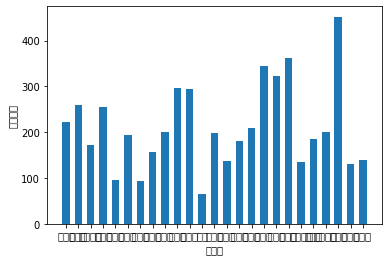

In [318]:
x = location_data.index.to_list()
y = location_data['지역'].to_list()

plt.xlabel('지역별')				#그래프 x축 이름(label) 지정
plt.ylabel('확진자수')				#그래프 y축 이름(label) 지정

plt.bar(x, y, width=0.6)


In [319]:
patient_df_modify['지역'].value_counts()

관악구     452
송파구     361
성북구     344
타시도     331
노원구     323
강남구     296
강서구     295
은평구     259
동작구     254
도봉구     223
서초구     210
중랑구     201
영등포구    200
강동구     199
구로구     193
양천구     186
마포구     180
동대문구    172
강북구     156
용산구     140
광진구     136
서대문구    135
성동구     130
기타      118
금천구      96
종로구      94
중구       64
Name: 지역, dtype: int64

In [320]:
a = patient_df_modify['지역'].value_counts().to_list()

In [321]:
print(a)

[452, 361, 344, 331, 323, 296, 295, 259, 254, 223, 210, 201, 200, 199, 193, 186, 180, 172, 156, 140, 136, 135, 130, 118, 96, 94, 64]


In [322]:
print(type(a[0]))

<class 'int'>


#### 가설: 확진자 수가 많은 지역은 인접하게 위치하고 있을 것이다.

지도 라이브러리 Folium 이용

In [414]:
import folium

In [454]:
# 지역별 위도와 경로를 리스트로 반환하는 함수

def coordinate(location):
  point_location = []
  idx = location_df[location_df['시군구명_한글'] == location].index
  idx = int(idx[0])
  latitude = location_df.iloc[idx]['위도']
  longitude = location_df.iloc[idx]['경도']
  point_location.append(latitude)
  point_location.append(longitude)
  return point_location

In [456]:
import requests
import json

# 서울 행정구역 json raw파일(githubcontent)
r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
c = r.content
seoul_geo = json.loads(c)

In [455]:
m = folium.Map(
    location=coordinate('중구'),
    zoom_start=11, 
)

m

In [458]:
m = folium.Map(
    location=coordinate('중구'),
    zoom_start=11, 
    tiles='cartodbpositron'
)

folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(m)

m

### 2. 확진일

월별 통계를 확인하기 위해 '월.일'로 된 정보를 '월'로 변경 

In [323]:
patient_df_modify['확진일']

0       10.21.
1       10.21.
2       10.21.
3       10.21.
4       10.21.
         ...  
5743     1.31.
5744     1.30.
5745     1.30.
5746     1.30.
5747     1.24.
Name: 확진일, Length: 5748, dtype: object

In [324]:
def date_to_month(date):
  date = date.split('.')[0]
  return int(date)

In [325]:
patient_df_modify['확진월'] = patient_df_modify['확진일'].apply(date_to_month)

In [326]:
patient_df_modify.head()

,연번,확진일,환자번호,지역,여행력,접촉력,확진월
0,5748,10.21.,25530,양천구,NaN,감염경로 조사중,10
1,5747,10.21.,25528,강동구,NaN,강남서초 지인모임,10
2,5746,10.21.,25525,강남구,NaN,기타 확진자 접촉,10
3,5745,10.21.,25517,관악구,NaN,감염경로 조사중,10
4,5744,10.21.,25504,관악구,NaN,기타 확진자 접촉,10


In [327]:
# 확진월을 가장 앞으로 변경

col1=patient_df_modify.columns[-1:].to_list()
col2=patient_df_modify.columns[:-1].to_list()
col2.insert(1, col1[0])

patient_df_modify = patient_df_modify[col2]

patient_df_modify.head()

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
0,5748,10,10.21.,25530,양천구,NaN,감염경로 조사중
1,5747,10,10.21.,25528,강동구,NaN,강남서초 지인모임
2,5746,10,10.21.,25525,강남구,NaN,기타 확진자 접촉
3,5745,10,10.21.,25517,관악구,NaN,감염경로 조사중
4,5744,10,10.21.,25504,관악구,NaN,기타 확진자 접촉


In [328]:
patient_df_modify['확진월'].value_counts()

8     2416
9     1304
6      460
10     425
3      391
7      281
5      228
4      156
2       80
1        7
Name: 확진월, dtype: int64

In [329]:
monthly_data = pd.DataFrame(patient_df_modify['확진월'].value_counts())

In [330]:
monthly_data

,확진월
8,2416
9,1304
6,460
10,425
3,391
7,281
5,228
4,156
2,80
1,7


In [331]:
monthly_data.index

Int64Index([8, 9, 6, 10, 3, 7, 5, 4, 2, 1], dtype='int64')

In [332]:
monthly_data = monthly_data.sort_index()

In [333]:
monthly_data

,확진월
1,7
2,80
3,391
4,156
5,228
6,460
7,281
8,2416
9,1304
10,425


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text

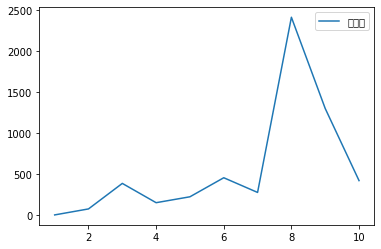

In [334]:
monthly_data.plot()

<BarContainer object of 10 artists>

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

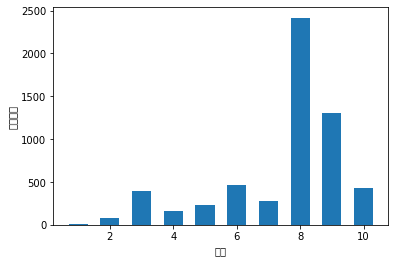

In [335]:
x = monthly_data.index.to_list()
y = monthly_data['확진월'].to_list()

plt.xlabel('월별')				#그래프 x축 이름(label) 지정
plt.ylabel('확진자수')				#그래프 y축 이름(label) 지정

plt.bar(x, y, width=0.6)


확진월 통계 확인 결과 8월에 급증한 것을 볼 수 있었다. 

#### 가설: 8월에 확진자수가 급증한 것은 휴가 혹은 방학기간과 관련있을 것이다.

In [336]:
aug_data = patient_df_modify[patient_df_modify['확진월'] == 8]

In [337]:
aug_data

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
1271,4477,8,8.31.,20132,타시도,NaN,감염경로 조사중
1272,4476,8,8.25.,17968,타시도,NaN,성북구 사랑제일교회 관련
1273,4475,8,8.26.,18821,타시도,NaN,타시도 확진자 접촉
1274,4474,8,8.27.,18818,타시도,NaN,기타 확진자 접촉
1504,4244,8,8.30.,20116,타시도,NaN,감염경로 조사중
...,...,...,...,...,...,...,...
4140,1608,8,8.2.,14382,용산구,일본,해외 접촉 추정
4141,1607,8,8.1.,14364,양천구,NaN,송파구 확진자 접촉
4142,1606,8,8.1.,14362,종로구,NaN,종로구 지인모임 신명투자
4144,1604,8,8.1.,14366,강서구,NaN,강서구 요양시설관련


In [341]:
aug_data['여행력'].value_counts()

미국         13
필리핀         4
카자흐스탄       3
인도          3
영국          2
러시아         2
중국          2
이집트         2
사우디아라비아     2
베트남         2
일본          2
우즈베키스탄      1
홍콩          1
멕시코         1
에콰도르        1
방글라데시       1
스페인         1
케냐          1
프랑스         1
인도네시아       1
에티오피아       1
터키          1
21263       1
독일          1
이라크         1
Name: 여행력, dtype: int64

8월이 휴가철이므로 혹시 몰라 해외 입국을 조회해보니 그렇게 많지 않았음. 당시 전세계적 팬더믹으로 해외 이동이 별로 없었던 점을 감안하면 해외 유입과 휴가기간은 연관이 없을 것이라고 판단함. 만약 휴가기간이 영향을 미쳤다면 국내 여행이 주요한 원인으로 생각되지만 주어진 데이터에서는 국내 여행과 관련된 데이터가 없었기에 확인할 수 없었음.  

아래 첨부자료를 보면 코로나로 인해 서울 시민 중 많은 사람들이 휴가지로 국내 명승지나 국내 캠핑을 선택한 것을 알 수 있었음

[https://drive.google.com/file/d/1l_CHhdg7mwM9xRlW_75ws-GGAFGP_gEQ/view?usp=sharing]

8월에 확진자가 급증한 다른 이유를 찾기 위해 '접촉력'을 확인해봄

In [338]:
aug_data['접촉력'].value_counts()

성북구 사랑제일교회 관련          628
확인 중                   444
기타 확진자 접촉              422
8.15서울도심집회             113
타시도 확진자 접촉              92
                      ... 
서초구 확진자 접촉               1
고양시 반석교회 관련 (케네디상가)      1
종로구 확진자 접촉               1
양천구 되새김교회                1
관악구 김혜근의원                1
Name: 접촉력, Length: 89, dtype: int64

In [339]:
len(aug_data['접촉력'].value_counts())

89

In [340]:
aug_data['접촉력'].value_counts()[:30]

성북구 사랑제일교회 관련         628
확인 중                  444
기타 확진자 접촉             422
8.15서울도심집회            113
타시도 확진자 접촉             92
해외 접촉 추정               47
용인시 우리제일교회 관련          40
성북구 체대입시 관련            39
극단 산 관련                36
노원구 빛가온교회 관련           35
구로구 아파트 관련             34
용인시 우리제일교회             33
동작구 소재 서울신학교           30
여의도 순복음교회 관련           29
골드트레인                  23
동작구 진흥글로벌              21
롯데리아 종사자 모임            21
강동구 어린이집               17
영등포구 권능교회              17
다래경매 관련                17
관악구 요양병원               11
영등포 IFC몰 오케스트로         10
감염경로 조사중               10
은평구 헤어콕 관련              9
고양시 반석교회 관련(케네디상가)      9
현대커머셜                   8
동대문구 sk탁구클럽             8
종로구 혜화경찰서 관련            7
KT가좌지사 관련               7
골드트레인 관련                7
Name: 접촉력, dtype: int64

8월에 확진자가 급증한 이유를 확인해보기 위해 '접촉력'을 분석한 결과 교회 관련하여 확진자가 많이 발생한 것을 확인할 수 있었음. 당시 뉴스를 검색해보니 관련 교회와 광복절 집회 관련한 기사가 많은 것을 찾을 수 있었음

추가로 코로나의 경우 겨울철에 독감과 함께 확진자수가 많이 증가하므로 10월 이후 독감이 유행하는 11-12월에는 확진자가 증가할 것이라고 예측 가능

아래 자료는 서울시만이 아닌 대한민국 전체 확진자 추이를 보여줌

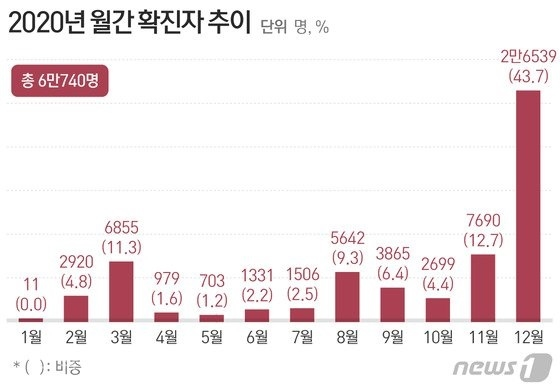

In [342]:
patient_df_modify.head()

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
0,5748,10,10.21.,25530,양천구,NaN,감염경로 조사중
1,5747,10,10.21.,25528,강동구,NaN,강남서초 지인모임
2,5746,10,10.21.,25525,강남구,NaN,기타 확진자 접촉
3,5745,10,10.21.,25517,관악구,NaN,감염경로 조사중
4,5744,10,10.21.,25504,관악구,NaN,기타 확진자 접촉


### 3. 여행력

In [343]:
patient_df_modify['여행력'].value_counts()

미국                      153
영국                       50
필리핀                      25
인도                       13
프랑스                      13
                       ... 
프랑스 스페인 독일 이탈리아 네덜란드      1
호주 인도네시아                  1
포르투칼                      1
미국 캐나다 멕시코                1
우한 교민                     1
Name: 여행력, Length: 82, dtype: int64

In [344]:
patient_df_modify['여행력'].unique()

array([nan, '키르기스스탄', '미국', '인도', '이란', '체코', '폴란드', '프랑스', '필리핀',
       '방글라데시', '일본', '브라질', '우즈베키스탄', '요르단', '쿠웨이트', '인도네시아', '우간다',
       '몰타', '영국', '네팔', '카타르', '우크라이나', '에콰도르', '키르기즈스탄', '파라과이',
       '멕시코 미국', '카자흐스탄', '독일', '중국', '이집트', '21263', '터키', '사우디아라비아',
       '베트남', '에티오피아', '스페인', '케냐', '멕시코', '홍콩', '러시아', '이라크', '모로코 터키',
       '나이지리아', '미국 멕시코', '페루', '아랍에미리트', 'UAE', '파키스탄', '아일랜드', '콩코 프랑스',
       '캐나다', '페루 미국', '프랑스 스페인 독일 이탈리아 네덜란드', '팔라우', '호주 인도네시아', '이탈리아',
       '포르투칼', '미국 캐나다 멕시코', '미국 뉴욕', '오스트리아', '미국 브라질', '태국',
       '아르헨티나 볼리비아 브라질', '말레이시아', '필리핀 마닐라', '브라질 아르헨티아 칠레 볼리비아',
       '프랑스 독일', '미국 캐나다', '스페인 카타르', '이탈리아 프랑스', '체코 헝가리 오스트리아 이탈리아 프랑스',
       '모로코 프랑스 오스트리아', '영국 프랑스', '스페인체코', '독일프랑스', '프랑스 스페인', '스페인 프랑스',
       '이탈리아 독일 홍콩', '중국 청도', '우한교민', '중국 우한시', '싱가포르', '우한 교민'],
      dtype=object)

#### 가설: 여행력이 있는 대부분의 경우 접촉력이 해외와 관련되었을 것이다. 

In [360]:
traveler_data = patient_df_modify.copy()

In [361]:
traveler_data.head()

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
0,5748,10,10.21.,25530,양천구,NaN,감염경로 조사중
1,5747,10,10.21.,25528,강동구,NaN,강남서초 지인모임
2,5746,10,10.21.,25525,강남구,NaN,기타 확진자 접촉
3,5745,10,10.21.,25517,관악구,NaN,감염경로 조사중
4,5744,10,10.21.,25504,관악구,NaN,기타 확진자 접촉


In [362]:
traveler_data = traveler_data.drop(['확진일', '환자번호'], axis = 1)

In [363]:
traveler_data.head()

,연번,확진월,지역,여행력,접촉력
0,5748,10,양천구,NaN,감염경로 조사중
1,5747,10,강동구,NaN,강남서초 지인모임
2,5746,10,강남구,NaN,기타 확진자 접촉
3,5745,10,관악구,NaN,감염경로 조사중
4,5744,10,관악구,NaN,기타 확진자 접촉


In [364]:
traveler_data = traveler_data.dropna(subset = ['여행력'])

In [365]:
traveler_data.head()

,연번,확진월,지역,여행력,접촉력
18,5730,10,기타,키르기스스탄,해외 유입
19,5729,10,기타,키르기스스탄,해외 유입
21,5727,10,강동구,미국,해외 유입
25,5723,10,기타,인도,해외 유입
47,5701,10,용산구,이란,해외 유입


In [368]:
len(traveler_data)

459

In [366]:
traveler_data['접촉력'].unique()

array(['해외 유입', '해외 접촉 추정', '확인 중', '기타 확진자 접촉', '성북구 사랑제일교회 관련',
       '해외접촉 추정', '#9641 접촉', '#8057 접촉', '해외 접촉', '#6959 접촉(추정)'],
      dtype=object)

In [367]:
traveler_data['접촉력'].value_counts()

해외 접촉 추정         413
해외 접촉             22
해외 유입             14
확인 중               3
해외접촉 추정            2
기타 확진자 접촉          1
성북구 사랑제일교회 관련      1
#9641 접촉           1
#8057 접촉           1
#6959 접촉(추정)       1
Name: 접촉력, dtype: int64

여행력이 있는 총 459명 중에서 대다수의 경우가 해외 접촉이 원인이 되어 확진된 것을 알 수 있었다. 

In [369]:
traveler_data['지역'].value_counts()

강남구     49
기타      36
용산구     31
마포구     30
동작구     26
송파구     25
서초구     25
성동구     19
타시도     19
서대문구    19
강동구     18
관악구     17
성북구     17
노원구     15
강서구     14
도봉구     13
종로구     11
구로구     11
중랑구     10
영등포구    10
중구       9
동대문구     9
양천구      8
은평구      8
광진구      5
금천구      3
강북구      2
Name: 지역, dtype: int64

여행력이 있는 최다 지역이 강남구였고 어느 지역을 가장 많이 여행했는지 확인해보고자 함

In [371]:
traveler_data_gangnam = traveler_data[traveler_data['지역'] == '강남구']

In [372]:
traveler_data_gangnam

,연번,확진월,지역,여행력,접촉력
278,5470,10,강남구,미국,해외 접촉 추정
279,5469,10,강남구,미국,해외 접촉 추정
280,5468,10,강남구,미국,해외 접촉 추정
996,4752,9,강남구,미국,해외 접촉 추정
1722,4026,9,강남구,인도네시아,해외 접촉 추정
1723,4025,9,강남구,멕시코 미국,해외 접촉 추정
1724,4024,9,강남구,미국,해외 접촉 추정
1860,3888,8,강남구,미국,해외 접촉 추정
4886,862,5,강남구,멕시코,해외 접촉 추정
4897,851,5,강남구,방글라데시,해외 접촉 추정


In [373]:
traveler_data_gangnam['여행력'].value_counts()

미국                29
영국                 5
인도네시아              2
멕시코                2
필리핀                2
이탈리아 프랑스           2
멕시코 미국             1
방글라데시              1
러시아                1
아일랜드               1
스페인                1
아르헨티나 볼리비아 브라질     1
이탈리아               1
Name: 여행력, dtype: int64

미국에서 유입된 경우가 가장 많았음

In [374]:
patient_df_modify.head()

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
0,5748,10,10.21.,25530,양천구,NaN,감염경로 조사중
1,5747,10,10.21.,25528,강동구,NaN,강남서초 지인모임
2,5746,10,10.21.,25525,강남구,NaN,기타 확진자 접촉
3,5745,10,10.21.,25517,관악구,NaN,감염경로 조사중
4,5744,10,10.21.,25504,관악구,NaN,기타 확진자 접촉


### 4. 접촉력

In [375]:
patient_df_modify['접촉력'].unique()

array(['감염경로 조사중', '강남서초 지인모임', '기타 확진자 접촉', '관악구 삼모스포렉스Ⅱ',
       '도봉구 예마루데이케어센터', '도봉구 다나병원', '강남구 CJ텔레닉스', '해외 유입', '타시도 확진자 접촉',
       '송파구 잠언의료기', '강남구 CJ텔레닉스 관련', '강동구 행복데이케어센터', '중랑구 이마트 상봉점',
       '해외 접촉 추정', '영등포구 방문판매업체 관련', '중구 소재 콜센터', '동작구 가족관련',
       '서대문구 소재 장례식장', '관악구 식당관련', '영등포구 소모임', '송파구 서민국수', '중구 소재 빌딩 관련',
       '마포구 서울디자인 고등학교', '타시도 확진자 접촉(강원강릉시지인모임)', '강남승광빌딩 관련',
       '관악구 사랑나무 어린이집', '관악구 큰믿음유신감리교회', '동대문구 성경모임(발산대우주어린이집)',
       '강북구 북서울 꿈의교회', '강남구 소재 대우디오빌플러스', '영등포구 LG트윈타워', '부산시 방문주사 관련',
       '서초구 소재 카페 관련', '관악구 지인모임', '동작구 부동산회사', '관악구 휘트니스 관련', '강남구 삼성화재',
       '양천구 양천경찰서', '서초구 LG 유플러스', '고양시부부관련', '관악구 가족 관련', '관악구 식당 관련',
       '고양시부부관련(마포구어린이집&서초구우체국)', '관악구가족 관련(가가호호데이케어센터)', '관악구 삼모스포렉스',
       '신도림 역사 관련', '강남구 디와이디벨로먼트', '동대문구 성경모임', '송파구 우리교회', '중랑구 서울의료원',
       '종로구 서울대병원', '성동구 덕수고 야구부', '프로그래머 지인모임', '강남구 신도벤처타워',
       '강남구 K보건산업', '건축설명회', '종로구청 관련', '강남구 통신판매업', '도봉구 소재 아파트 관련',
       '영등포 소재 증권회사', '서대문구 세브란스병원', 

In [384]:
contact_list = patient_df_modify['접촉력'].unique()

In [385]:
print(len(contact_list))

295


In [376]:
patient_df_modify['접촉력'].value_counts()

기타 확진자 접촉        818
성북구 사랑제일교회 관련    641
확인 중             586
해외 접촉 추정         415
감염경로 조사중         373
                ... 
#10407 접촉          1
부산시 방문주사 관련        1
#9641 접촉           1
#9800 접촉           1
#3 접촉              1
Name: 접촉력, Length: 295, dtype: int64

가장 많은 확진자가 나온 접촉력을 분석해보고자 함

'확인중'은 우선 제거: 전체 중 10%가 '확인 중'이라 꽤 많은 수지만 원할한 분석을 위해 우선은 삭제하기로 함 

In [378]:
not_clear = patient_df_modify[patient_df_modify['접촉력'] == '확인 중'].index

In [379]:
print(not_clear)

Int64Index([1790, 1791, 1792, 1796, 1802, 1803, 1809, 1811, 1812, 1816,
            ...
            5123, 5153, 5162, 5173, 5175, 5184, 5196, 5220, 5223, 5272],
           dtype='int64', length=586)


In [380]:
contact_data = patient_df_modify.drop(not_clear)

In [381]:
contact_data.head()

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
0,5748,10,10.21.,25530,양천구,NaN,감염경로 조사중
1,5747,10,10.21.,25528,강동구,NaN,강남서초 지인모임
2,5746,10,10.21.,25525,강남구,NaN,기타 확진자 접촉
3,5745,10,10.21.,25517,관악구,NaN,감염경로 조사중
4,5744,10,10.21.,25504,관악구,NaN,기타 확진자 접촉


In [382]:
len(contact_data) # 5748 - 586 = 5162

5162

In [387]:
contact_data['접촉력'].value_counts()[:20]

기타 확진자 접촉        818
성북구 사랑제일교회 관련    641
해외 접촉 추정         415
감염경로 조사중         373
타시도 확진자 접촉       244
이태원 클럽 관련        139
8.15서울도심집회       126
리치웨이 관련          119
도봉구 다나병원          68
구로구 콜센터 관련        60
노원구 빛가온교회 관련      46
성북구 체대입시 관련       43
양천구 운동시설 관련       43
요양시설 관련           43
확인중               42
구로구 교회 관련         41
용인시 우리제일교회 관련     41
강남구 K보건산업         37
서대문구 세브란스병원       37
수도권 개척교회 관련       37
Name: 접촉력, dtype: int64

In [391]:
for contact in contact_list:
  if '구로' in str(contact):
    print(contact)

구로구 아파트 관련
구로구 보성운수
구로구 확진자 접촉
구로구 교회 관련
구로구 콜센터 관련
구로구 콜센터 접촉


특정 사건과 관련된 확진자의 경우 한 시기에 확진자가 몰려있게 된다. 

ex) 구로구 콜센터와 관련된 확진자는 3월에 집중되어 있다.

In [396]:
guro_center_1= contact_data [contact_data['접촉력'] == '구로구 콜센터 관련']

In [400]:
guro_center_1

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
5433,315,3,3.20.,8824,관악구,NaN,구로구 콜센터 관련
5448,300,3,3.20.,8782,구로구,NaN,구로구 콜센터 관련
5452,296,3,3.19.,8603,동작구,NaN,구로구 콜센터 관련
5457,291,3,3.19.,8598,강서구,NaN,구로구 콜센터 관련
5473,275,3,3.18.,8461,양천구,NaN,구로구 콜센터 관련
5475,273,3,3.18.,8529,성북구,NaN,구로구 콜센터 관련
5486,262,3,3.16.,8254,용산구,NaN,구로구 콜센터 관련
5534,214,3,3.11.,7805,서대문구,NaN,구로구 콜센터 관련
5540,208,3,3.11.,7857,중랑구,NaN,구로구 콜센터 관련
5548,200,3,3.10.,7555,구로구,NaN,구로구 콜센터 관련


In [397]:
guro_center_2 = contact_data [contact_data['접촉력'] == '구로구 콜센터 접촉']

In [401]:
guro_center_2

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
5503,245,3,3.14.,8140,영등포구,NaN,구로구 콜센터 접촉


In [402]:
guro_3 = contact_data [contact_data['접촉력'] == '구로구 아파트 관련']

In [403]:
guro_3

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
1205,4543,9,9.10.,21812,금천구,NaN,구로구 아파트 관련
1761,3987,9,9.01.,20438,금천구,NaN,구로구 아파트 관련
2054,3694,8,8.29.,19671,구로구,NaN,구로구 아파트 관련
2180,3568,8,8.28.,21249,구로구,NaN,구로구 아파트 관련
2268,3480,8,8.27.,18955,구로구,NaN,구로구 아파트 관련
2315,3433,8,8.27.,18986,구로구,NaN,구로구 아파트 관련
2319,3429,8,8.27.,18848,금천구,NaN,구로구 아파트 관련
2320,3428,8,8.27.,18902,타시도,NaN,구로구 아파트 관련
2399,3349,8,8.26.,18469,금천구,NaN,구로구 아파트 관련
2421,3327,8,8.26.,18705,구로구,NaN,구로구 아파트 관련


In [404]:
for contact in contact_list:
  if '교회' in str(contact):
    print(contact)

관악구 큰믿음유신감리교회
강북구 북서울 꿈의교회
송파구 우리교회
노원구 빛가온교회 관련
성북구 사랑제일교회 관련
영등포구 권능교회
용인시 우리제일교회 관련
성북구 벧엘장로교회
여의도 순복음교회 관련
양천구 되새김교회 관련
고양시 반석교회(케네디상가) 관련
용인시 우리제일교회
양천구 되새김 교회
고양시 반석교회(케네디상가)
고양시 반석교회 관련 (케네디상가)
양천구 되새김교회
고양시 반석교회 관련(케네디상가)
선교회 소모임
송파구 교회관련
왕성교회 관련
대전 꿈꾸는 교회
수도권 개척교회 관련
한국대학생선교회 관련
강남구 동인교회 관련
구로구 교회 관련
명성교회 관련
신천지대구교회 관련
대구 방문(명성교회)


In [405]:
sungbook_church = contact_data [contact_data['접촉력'] == '성북구 사랑제일교회 관련']

In [406]:
sungbook_church

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
1272,4476,8,8.25.,17968,타시도,NaN,성북구 사랑제일교회 관련
1500,4248,9,9.04.,20962,성북구,NaN,성북구 사랑제일교회 관련
1554,4194,9,9.03.,20833,은평구,NaN,성북구 사랑제일교회 관련
1561,4187,9,9.03.,20885,도봉구,NaN,성북구 사랑제일교회 관련
1575,4173,9,9.02.,20723,강동구,NaN,성북구 사랑제일교회 관련
...,...,...,...,...,...,...,...
4000,1748,8,8.13.,14807,성북구,NaN,성북구 사랑제일교회 관련
4001,1747,8,8.13.,14806,성북구,NaN,성북구 사랑제일교회 관련
4007,1741,8,8.13.,14804,동대문구,NaN,성북구 사랑제일교회 관련
4010,1738,8,8.13.,14783,성북구,NaN,성북구 사랑제일교회 관련


In [407]:
sungbook_church['확진월'].value_counts()

8    628
9     13
Name: 확진월, dtype: int64

In [408]:
for contact in contact_list:
  if '집회' in str(contact):
    print(contact)

8.15서울도심집회


In [411]:
gwangbok_protest = contact_data [contact_data['접촉력'] == '8.15서울도심집회']

In [412]:
gwangbok_protest

,연번,확진월,확진일,환자번호,지역,여행력,접촉력
1074,4674,9,9.13.,22192,마포구,NaN,8.15서울도심집회
1232,4516,9,9.09.,21669,노원구,NaN,8.15서울도심집회
1313,4435,9,9.07.,21494,강서구,NaN,8.15서울도심집회
1371,4377,9,9.07.,21314,구로구,NaN,8.15서울도심집회
1406,4342,9,9.06.,21210,노원구,NaN,8.15서울도심집회
...,...,...,...,...,...,...,...
3333,2415,8,8.19.,16123,도봉구,NaN,8.15서울도심집회
3346,2402,8,8.19.,16239,중랑구,NaN,8.15서울도심집회
3378,2370,8,8.19.,16129,강북구,NaN,8.15서울도심집회
3417,2331,8,8.18.,15983,종로구,NaN,8.15서울도심집회


In [413]:
gwangbok_protest['확진월'].value_counts()

8    113
9     13
Name: 확진월, dtype: int64

8월에 확진자수 급증의 원인이 되었던 성북구 사랑제일교회와 서울도심집회 관련 확진자수는 8월에 집중되어 있음 

확진 경로는 큰 사건들 관련, 확진자 접촉, 해외 유입으로 분류할 수 있었음

### 4. 지역 & 월별 확진자